# 0.0 Imports and directories

In [1]:
import MySQLdb                     
from sqlalchemy import create_engine

import pandas as pd
import numpy as np

import os
import s3fs

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn import metrics

import umap.umap_ as umap


In [2]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
DATA_DIR = os.path.join(BASE_DIR, 'feature_eng', 'data')

# 1.0 EDA

In [3]:
df = pd.read_csv('s3://insiders-db/ft_df.csv')

## 1.1 Space study

In [4]:
cols_selected = ['gross_revenue', 'last_purchase', 'avg_recency_days','qt_products', 'qt_returns']
df = df[ ['customer_id'] + cols_selected ].dropna()

In [5]:
df.shape

(2968, 6)

### 1.2 Tree-based Embedding

In [6]:
X = df[cols_selected].drop(columns = ['gross_revenue'])
y = df.gross_revenue

In [7]:
# model definition
rf = pickle.load(open('s3://insiders-db/rf_model.pkl', 'rb'))

# Leaf df
df_leaf = pd.DataFrame(rf.apply(X))


In [8]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3401,2831,3726,3640,3582,3696,3572,3621,3664,3480,...,3404,3326,3374,3641,3575,3673,3675,3413,3581,3627
1,3282,2770,3688,2436,2504,2567,2681,3598,2769,3450,...,2439,3258,2322,2221,3389,2460,2784,3329,2606,3525
2,3490,2360,3697,3625,3573,3671,2761,3562,2728,3097,...,3369,3318,3492,3581,3505,3617,2632,3369,3572,3591
3,1225,824,907,370,888,506,659,1105,1884,1601,...,1205,1672,810,801,1615,1880,901,1166,961,920
4,481,416,411,894,917,803,1284,463,641,734,...,97,645,877,552,766,583,100,141,1316,26


In [9]:
# Reduce dimensionality
reducer = pickle.load(open('s3://insiders-db/umap.pkl', 'rb'))

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

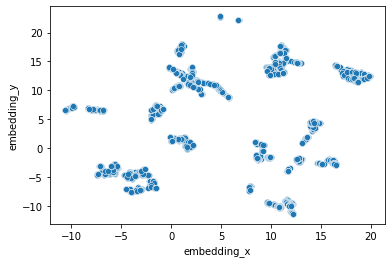

In [10]:
# Reduce dimensionality
embedding = reducer.transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

# 2.0 Model Training

In [11]:
k = 8

X = df_tree.copy()

## model definition
gm = KMeans( n_clusters = k, random_state = 42 ) 

# model training
gm.fit( X )

# model predict
labels = gm.predict(  X )


In [12]:
## SS ( Silhouette Score )
print( f'''SS value: {metrics.silhouette_score( X, labels, metric='euclidean') }''')

SS value: 0.6290104985237122


# 3.0 Cluster Profile

In [13]:
df = df[ ['customer_id'] + cols_selected].copy()
df['cluster'] = labels
df.head()

,customer_id,gross_revenue,last_purchase,avg_recency_days,qt_products,qt_returns,cluster
0,17850,5391.21,372.0,35.500000,297.0,40.0,4
1,13047,3232.59,56.0,27.250000,171.0,35.0,7
2,12583,6705.38,2.0,23.187500,232.0,50.0,4
3,13748,948.25,95.0,92.666667,28.0,0.0,3
4,15100,876.00,333.0,8.600000,3.0,22.0,3


# 4.0 Deploy

In [14]:
# changing dtypes

to_int = ['qt_products', 'qt_returns', 'last_purchase']

for col in to_int:
    df[col] = df[col].astype(int)

df.dtypes

customer_id           int64
gross_revenue       float64
last_purchase         int32
avg_recency_days    float64
qt_products           int32
qt_returns            int32
cluster               int32
dtype: object

In [27]:
# create table
tb_insiders =  '''

CREATE TABLE insiders 

(
customer_id         INTEGER,
gross_revenue       REAL,
last_purchase       INTEGER,
avg_recency_days    REAL, 
qt_products         INTEGER,
qt_returns          INTEGER,
cluster             INTEGER
)
'''


host ='insiders-db.ch0jsb1xo6iu.us-east-2.rds.amazonaws.com'
port = '3306'
db = 'insidersdb'
user = 'admin'
pwd = 'insiders123'

conn = create_engine(f'mysql://{user}:{pwd}@{host}:{port}/{db}')

conn.execute(tb_insiders)
# conn.commit()
# conn.close()


# # insert data
df.to_sql('insiders', con = conn, if_exists = 'append', index = False)

In [28]:
df.to_sql('insiders', con = conn, if_exists = 'append', index = False)
conn.close()